In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math
import scipy.sparse as sps

from scipy.sparse.linalg import cg
from scipy.integrate import odeint

from fastprogress import progress_bar

import jlinops
import sampi


In [2]:
ground_truth = jlinops.cameraman() + 1.0
img_shape = ground_truth.shape
L = 10
n = math.prod(ground_truth.shape)
A = jlinops.IdentityOperator( (n,n) )
A = jlinops.Gaussian2DBlurOperator(img_shape, blur_sigma=2.0)

np.random.seed(0)
noisy_signal = A.matvec(ground_truth.flatten())*np.random.gamma(shape=L, scale=1/L, size=n)

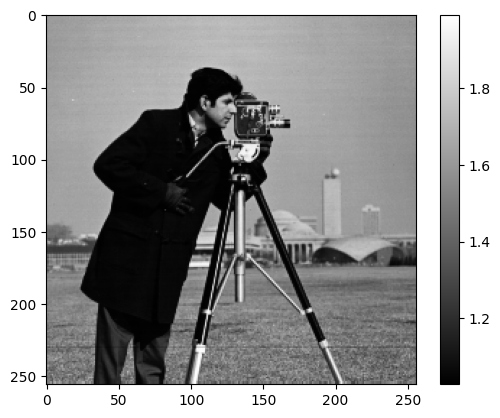

In [3]:
plt.imshow(ground_truth, cmap="gray")
plt.colorbar()
plt.show()

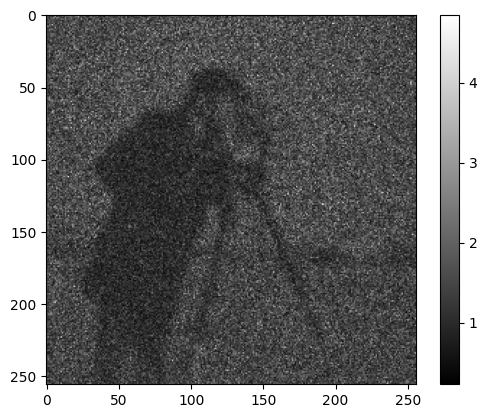

In [4]:
plt.imshow(noisy_signal.reshape(img_shape), cmap="gray")
plt.colorbar()
plt.show()

# AA method

In [21]:
class AADespecklingSolver2D:

    def __init__(self, A, f, hyperparams, L=1, grid_shape=None):

        # Bind
        assert grid_shape is not None, "must give a grid shape."
        self.grid_shape = grid_shape
        self.f = f
        self.A = A
        self.hyperparams = hyperparams
        self.L = L
        self.n = A.shape[1]

        # Build R
        self.R = jlinops.Neumann2D(grid_shape)

        # Misc
        self.m = self.n
        self.k = self.R.shape[0] # output size of regularization operator
    

    def solve(self, maxiter=100, dt=0.1, beta=0.1):

        # # Handle initialization
        # if u0 is None:
        #     u = np.ones(self.n)
        # else:
        #     u = u0

        # Initialize here
        u = self.f

        converged = False
        obj_val = self.objective(u)
        obj_vals = [obj_val]
        for j in progress_bar(range(maxiter)):

            # Grad
            grad_u = self.R @ u
            denom = np.sqrt( (np.linalg.norm(grad_u)**2) + (beta**2) )
            first_term = self.R.T @ (grad_u/denom)
            Au = self.A.matvec(u)
            second_term = self.hyperparams["reg_lam"]*L*self.A.rmatvec( (self.f - Au)/(Au**2)   )
            rhs = first_term + second_term

            # Take step
            u += dt*rhs

            # Track objective
            obj_val = self.objective(u)
            obj_vals.append(obj_val)
            
        data = {
            "u": u,
            "obj_vals": obj_vals,
        }

        return data


    def objective(self, u):
        """Evaluates the objective function.
        """

        Au = A.matvec(u)
        obj = L*( (np.log(Au) + self.f/Au  ).sum() + self.hyperparams["reg_lam"]*np.abs(self.R.matvec(u)).sum()    )
        
        return obj

# Test

In [44]:
hyperparams = {
    "reg_lam": 1e-1,
}

solver = AADespecklingSolver2D(A, noisy_signal, hyperparams=hyperparams, L=L, grid_shape=img_shape) 

In [45]:
data = solver.solve(maxiter=300, dt=0.1, beta=0.0001)

/var/folders/8y/4mq6cs_x20j1gp06wytwhlwm0000gn/T/ipykernel_92482/3491283335.py:66: RuntimeWarning: invalid value encountered in log
  obj = L*( (np.log(Au) + self.f/Au  ).sum() + self.hyperparams["reg_lam"]*np.abs(self.R.matvec(u)).sum()    )


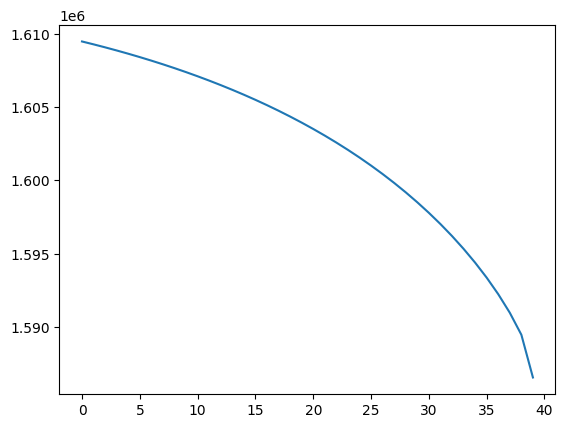

In [46]:
plt.plot(data["obj_vals"])
plt.show()

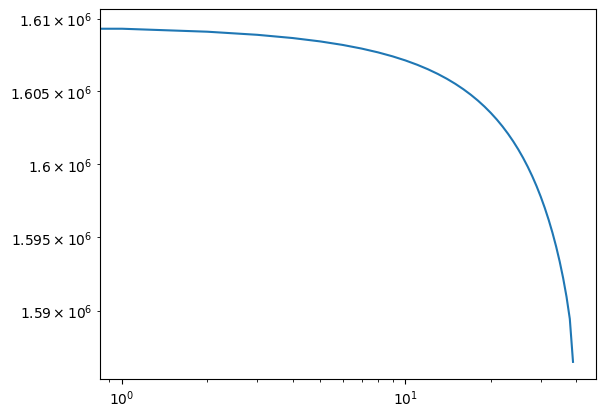

In [47]:
plt.loglog(data["obj_vals"])
plt.show()

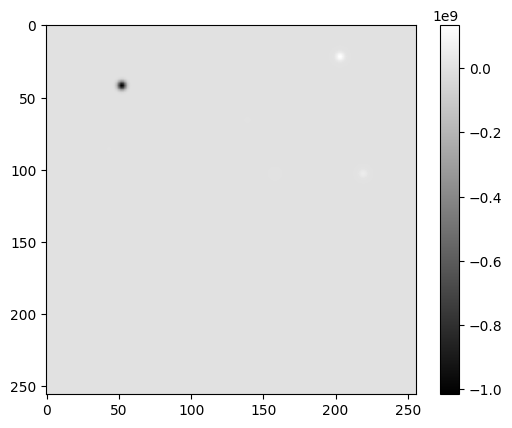

In [48]:
plt.imshow(data["u"].reshape(img_shape), cmap="gray")
plt.colorbar()
plt.show()

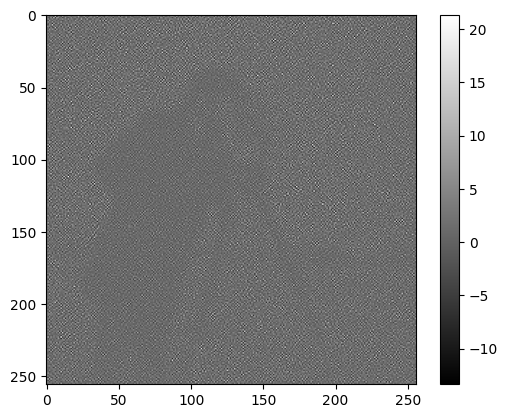

In [43]:
plt.imshow(noisy_signal.reshape(img_shape), cmap="gray")
plt.colorbar()
plt.show()